In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys
import math

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
class Obj:
    pass

In [5]:
params = Obj()
params.input_dim = 784
params.n_l1 = 1000
params.n_l2 = 1000
params.z_dim = 15
params.batch_size = 100
params.n_epochs = 1000
params.learning_rate = 0.001
params.beta1 = 0.9

In [6]:
results_path = './Results/Autoencoder'

In [7]:
def dense(x, n1, n2, name):
    """
    Used to create a dense layer.
    :param x: input tensor to the dense layer
    :param n1: no. of input neurons
    :param n2: no. of output neurons
    :param name: name of the entire dense layer.i.e, variable scope name.
    :return: tensor with shape [batch_size, n2]
    """
    with tf.variable_scope(name, reuse=None):
        xav_stddev = np.sqrt(2 / (n1 + n2))
        weights = tf.get_variable("weights", shape=[n1, n2],
                                  initializer=tf.random_normal_initializer(mean=0., stddev=xav_stddev))
        bias = tf.get_variable("bias", shape=[n2], initializer=tf.constant_initializer(0.0))
        out = tf.add(tf.matmul(x, weights), bias, name='matmul')
    return out

In [8]:
def encoder(x, params, reuse=False):
    """
    Encode part of the autoencoder
    :param x: input to the autoencoder
    :param reuse: True -> Reuse the encoder variables, False -> Create or search of variables before creating
    :return: tensor which is the hidden latent variable of the autoencoder.
    """
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.name_scope('Encoder'):
        e_dense_1 = tf.nn.relu(dense(x, params.input_dim, params.n_l1, 'e_dense_1'))
        e_dense_2 = tf.nn.relu(dense(e_dense_1, params.n_l1, params.n_l2, 'e_dense_2'))
        latent_variable = dense(e_dense_2, params.n_l2, params.z_dim, 'e_latent_variable')
    return latent_variable

In [9]:
def decoder(x, params, reuse=False):
    """
    Decoder part of the autoencoder
    :param x: input to the decoder
    :param reuse: True -> Reuse the decoder variables, False -> Create or search of variables before creating
    :return: tensor which should ideally be the input given to the encoder.
    """
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.name_scope('Decoder'):
        d_dense_1 = tf.nn.relu(dense(x, params.z_dim, params.n_l2, 'd_dense_1'))
        d_dense_2 = tf.nn.relu(dense(d_dense_1, params.n_l2, params.n_l1, 'd_dense_2'))
        #output = tf.nn.sigmoid(dense(d_dense_2, params.n_l1, params.input_dim, 'd_output'))
        output = dense(d_dense_2, params.n_l1, params.input_dim, 'd_output')
        return output

In [10]:
x_input = tf.placeholder(dtype=tf.float32, shape=[params.batch_size, params.input_dim], name='Input')
x_target = tf.placeholder(dtype=tf.float32, shape=[params.batch_size, params.input_dim], name='Target')
decoder_input = tf.placeholder(dtype=tf.float32, shape=[1, params.z_dim], name='Decoder_input')

In [11]:
with tf.variable_scope(tf.get_variable_scope()):
    encoder_output = encoder(x_input, params)
    decoder_output = decoder(encoder_output, params)
    

In [34]:
with tf.variable_scope(tf.get_variable_scope()):
    decoder_image = decoder(decoder_input, params, reuse=True)

In [12]:
# Loss
#loss = tf.reduce_mean(tf.square(x_target - decoder_output))
loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=decoder_output, labels=x_target)) #, reduction_indices=1)

In [13]:
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = params.learning_rate, beta1 = params.beta1).minimize(loss)

In [14]:
# Evaluaton
gen_accuracy = tf.sqrt(tf.reduce_mean(tf.square(x_target - tf.nn.sigmoid(decoder_output))))

In [15]:
sess = tf.InteractiveSession()

In [16]:
turn = 1
if turn ==1:
    sess.run(tf.global_variables_initializer())

In [17]:
saver = tf.train.Saver()

In [18]:
for num_epoch in range (params.n_epochs):
    batch_x, _ = mnist.train.next_batch(params.batch_size)
    if num_epoch % 10 == 0:
        ev = gen_accuracy.eval(feed_dict={x_input: batch_x, x_target: batch_x})
        sys.stdout.write('\rstep %d\t eval : %.5f' % (num_epoch, ev))
    optimizer.run(feed_dict={x_input: batch_x, x_target: batch_x})
    

step 990	 eval : 0.11512

In [20]:
x_test = mnist.test.next_batch(params.batch_size)
print(gen_accuracy.eval(feed_dict={x_input: batch_x, x_target: batch_x}))

0.103649


In [56]:
x_out = tf.nn.sigmoid(decoder_output).eval(feed_dict={x_input: batch_x})


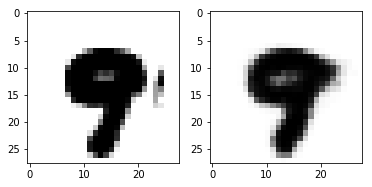

In [57]:
i = 2
plt.subplot(1,2,1)
plt.imshow(batch_x[i].reshape((28, 28)), cmap = 'gray_r')
plt.subplot(1,2,2)
plt.imshow(x_out[i].reshape((28, 28)), cmap = 'gray_r')


In [43]:
x_image = tf.nn.sigmoid(decoder_image).eval(feed_dict={decoder_input : np.zeros((1,params.z_dim))})

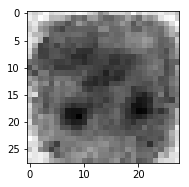

In [44]:
plt.subplot(1,2,2)
plt.imshow(x_image.reshape((28, 28)), cmap = 'gray_r')

In [45]:
liste_z = encoder_output.eval(feed_dict={x_input: batch_x})

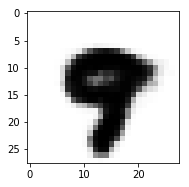

In [54]:
i = 2
x_image = tf.nn.sigmoid(decoder_image).eval(feed_dict={decoder_input : liste_z[i].reshape((1, 15))})
plt.subplot(1,2,1)
plt.imshow(x_image.reshape((28, 28)), cmap = 'gray_r')

In [50]:
liste_z[i]

array([-3.4071753 , -3.48638153, -3.14921498, -2.43544269, -2.9059155 ,
        8.10051537,  9.23005772, -6.68412685,  4.40728045, -4.26153421,
       -9.83212852,  6.39426422, -1.67523789, -8.72569466, -2.3876729 ], dtype=float32)

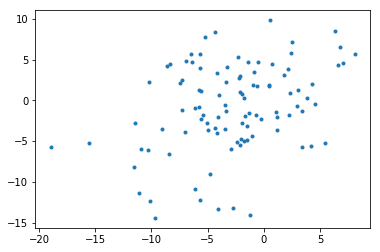

In [59]:
plt.plot(liste_z[:,0], liste_z[:,1], '.')